In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# download dataset
import gdown

url = 'https://drive.google.com/file/d/1HWl3kawJHxmGv1Ck69bvRIxOMz_9ZQ45/view?usp=sharing'
gdown.download(url=url, output='dataset.zip', quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1HWl3kawJHxmGv1Ck69bvRIxOMz_9ZQ45
To: /content/dataset.zip
100%|██████████| 620M/620M [00:07<00:00, 84.4MB/s]


'dataset.zip'

In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/train/
   creating: dataset/train/y_train/
  inflating: dataset/train/y_train/1588.npy  
  inflating: dataset/train/y_train/1371.npy  
  inflating: dataset/train/y_train/0459.npy  
  inflating: dataset/train/y_train/1484.npy  
  inflating: dataset/train/y_train/0940.npy  
  inflating: dataset/train/y_train/0827.npy  
  inflating: dataset/train/y_train/1784.npy  
  inflating: dataset/train/y_train/1689.npy  
  inflating: dataset/train/y_train/0101.npy  
  inflating: dataset/train/y_train/1245.npy  
  inflating: dataset/train/y_train/1161.npy  
  inflating: dataset/train/y_train/1552.npy  
  inflating: dataset/train/y_train/1726.npy  
  inflating: dataset/train/y_train/1018.npy  
  inflating: dataset/train/y_train/0544.npy  
  inflating: dataset/train/y_train/1913.npy  
  inflating: dataset/train/y_train/0038.npy  
  inflating: dataset/train/y_train/1626.npy  
  inflating: dataset/train/y_train/1374.npy  
  inflating: datas

In [ ]:
import glob                                                                                                                     # 파일 목록을 보여주기 위한 라이브러리
from tqdm import tqdm                                                                                                     # 반복수행에서 진행 단계를 보여주기 위한 라이브러리
import shutil                                                                                                                    # 파일 복사, 이동 등의 명령을 위한 라이브러리
from PIL import Image                                                                                                       # 이미지 파일 처리 라이브러리
import numpy as np                                                                                                          # 수치연산 라이브러리
import tensorflow as tf                                                                                                       # 텐서플로우 딥러닝 프레임워크 
import random                                                                                                                 # 난수 생성 라이브러리
import matplotlib.pyplot as plt                                                                                             # 시각화 라이브러리
from tqdm import tqdm

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Add, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 123                                                                                                                      # 이하 무작위로 결정되는 요소들의 난수를 고정하여 재현 가능하게 설정
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Get data

# train path
x_train_paths = glob.glob('./dataset/train/X_train/*.npy')[:300]
y_train_paths = [x.replace('/X_train', '/y_train') for x in x_train_paths]

# test path
x_test_paths = glob.glob('./dataset/test/X_test/*.npy')[:100]
y_test_paths = [x.replace('/X_test', '/y_test') for x in x_test_paths]

# num data
print('Xy train:', len(x_train_paths), len(y_train_paths))
print('Xy test:', len(x_test_paths), len(y_test_paths))


Xy train: 300 300
Xy test: 100 100


In [ ]:
def make_data_array(npy_paths):
    data_arr = []
    for npy_path in npy_paths:
        data = np.load(npy_path) # (224, 224, 20)
        data_arr.append(data)
    data_arr = np.array(data_arr, np.float64) # (N, 224, 224, 20)
    return data_arr

X_train = make_data_array(x_train_paths) / 255.
y_train = make_data_array(y_train_paths)
X_test = make_data_array(x_test_paths) / 255.
y_test = make_data_array(y_test_paths)

print('Xy train:', X_train.shape, y_train.shape)
print('Xy test:', X_test.shape, y_test.shape)


Xy train: (300, 224, 224, 20) (300, 224, 224, 5)
Xy test: (100, 224, 224, 20) (100, 224, 224, 5)


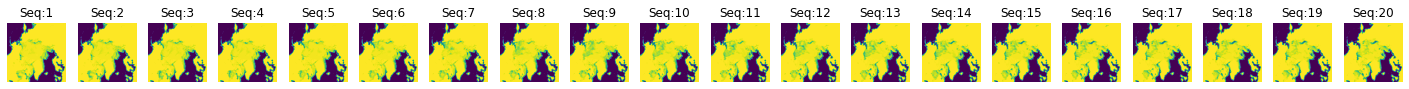

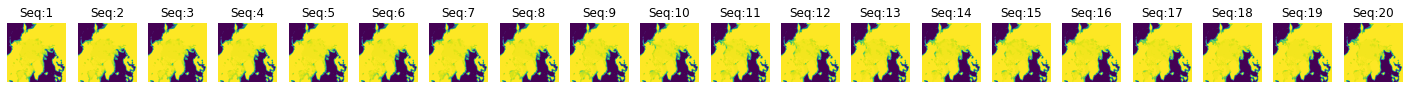

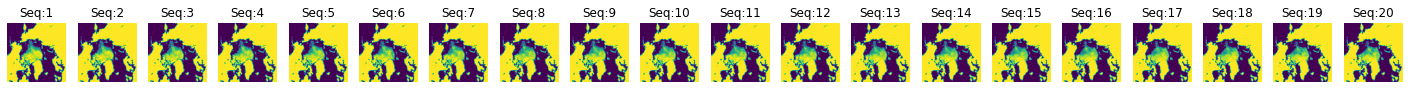

In [ ]:
# Data Visualization
for input_seq in X_train[:3]:
    fig = plt.figure(figsize=(25,5))
    for i in range(20):
        ax = fig.add_subplot(1,20,i+1)
        ax.imshow(input_seq[:, :, i])
        ax.set_axis_off()
        ax.set_title(f'Seq:{i+1}')
    plt.show()
    plt.close('all')

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 2
IN_LEN = 20
OUT_LEN = 5

# Model

In [ ]:
# UNet
def UNet(input_shape, output_size):
    # Encoder
    inputs = Input(shape=input_shape)
    enc1 = Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(inputs)
    enc1 = Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(enc1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(enc1)

    enc2 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(pool1)
    enc2 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(enc2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(enc2)

    enc3 = Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(pool2)
    enc3 = Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(enc3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(enc3)

    enc4 = Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(pool3)
    enc4 = Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(enc4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(enc4)

    # Bridge
    bridge = Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(pool4)

    # Decoder
    up4 = Conv2DTranspose(filters = 512, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same')(bridge)
    merge4 = concatenate([enc4, up4], axis = 3)
    dec4 = Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(merge4)
    dec4 = Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(dec4)

    up3 = Conv2DTranspose(filters = 256, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same')(dec4)
    merge3 = concatenate([enc3, up3], axis = 3)
    dec3 = Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(merge3)
    dec3 = Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(dec3)

    up2 = Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same')(dec3)
    merge2 = concatenate([enc2, up2], axis = 3)
    dec2 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(merge2)
    dec2 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(dec2)

    up1 = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same')(dec2)
    merge1 = concatenate([enc1, up1], axis = 3)
    dec1 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(merge1)
    dec1 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(dec1)

    outputs = Conv2D(filters = output_size, kernel_size = 1, activation = 'linear', padding = 'same')(dec1)

    return Model(inputs = inputs, outputs = outputs)

In [ ]:
tf.keras.backend.clear_session()

# 모델 구축
model = UNet(input_shape = (IMG_SIZE, IMG_SIZE, IN_LEN), output_size=OUT_LEN)
# 모델 컴파일
model.compile(optimizer=Adam(), loss='mae')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 2  0           []                               
                                0)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  11584       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
# model in/output test
samples = np.random.rand(1, 224, 224, 20)
pred = model.predict(samples)
print(samples.shape, pred.shape)

1/1 [==============================] - 9s 9s/step
(1, 224, 224, 20) (1, 224, 224, 5)


In [ ]:
# download pretrained weights
url = 'https://drive.google.com/file/d/1O4CMzISAOjsdGUQKX1M3R0BPG9app3Ae/view?usp=sharing'
gdown.download(url=url, output='pretrained.h5', quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1O4CMzISAOjsdGUQKX1M3R0BPG9app3Ae
To: /content/pretrained.h5
100%|██████████| 82.3M/82.3M [00:01<00:00, 72.6MB/s]


'pretrained.h5'

In [ ]:
# load pretrained weights
model.load_weights('pretrained.h5')

# save best weights
model_checkpoint = ModelCheckpoint(filepath='best.h5',
                                   save_weights_only=True,
                                   monitor='val_loss',
                                   mode='min',
                                   save_best_only=True,
                                   verbose=True)

# training start 
hist = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    callbacks=[model_checkpoint]
    )

Epoch 1/20
103/105 [============================>.] - ETA: 0s - loss: 0.0342
Epoch 1: val_loss improved from inf to 0.01993, saving model to best.h5
105/105 [==============================] - 7s 37ms/step - loss: 0.0340 - val_loss: 0.0199
Epoch 2/20
104/105 [============================>.] - ETA: 0s - loss: 0.0209
Epoch 2: val_loss improved from 0.01993 to 0.01879, saving model to best.h5
105/105 [==============================] - 3s 30ms/step - loss: 0.0209 - val_loss: 0.0188
Epoch 3/20
104/105 [============================>.] - ETA: 0s - loss: 0.0198
Epoch 3: val_loss improved from 0.01879 to 0.01771, saving model to best.h5
105/105 [==============================] - 3s 30ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 4/20
103/105 [============================>.] - ETA: 0s - loss: 0.0176
Epoch 4: val_loss improved from 0.01771 to 0.01578, saving model to best.h5
105/105 [==============================] - 3s 30ms/step - loss: 0.0175 - val_loss: 0.0158
Epoch 5/20
105/105 [============

In [ ]:
del X_train
del y_train

<Figure size 432x288 with 0 Axes>

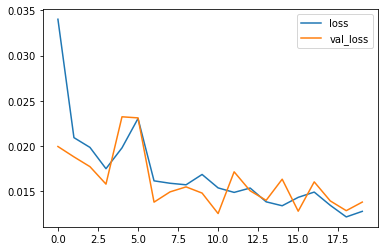

In [ ]:
import pandas as pd
hist_df = pd.DataFrame(data=hist.history)
plt.figure()
hist_df.plot()
plt.show()

In [ ]:
model.load_weights('best.h5')
mae_score = model.evaluate(X_test, y_test)
print('MAE:', mae_score)

4/4 [==============================] - 2s 215ms/step - loss: 0.0129
MAE: 0.012884769588708878


In [ ]:
# predict test data
preds = model.predict(X_test)
preds.shape

4/4 [==============================] - 0s 82ms/step


(100, 224, 224, 5)

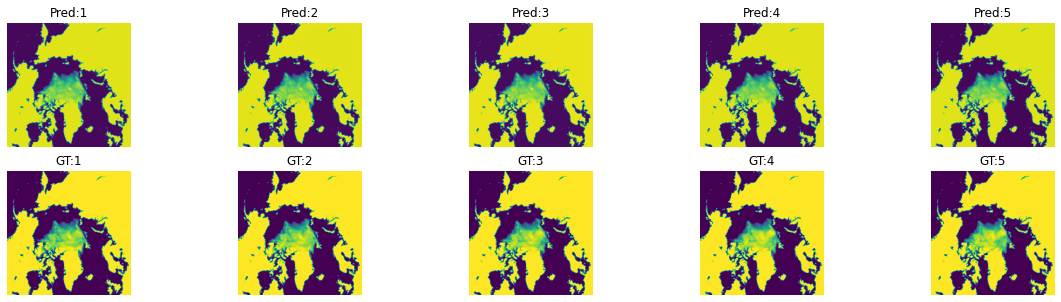

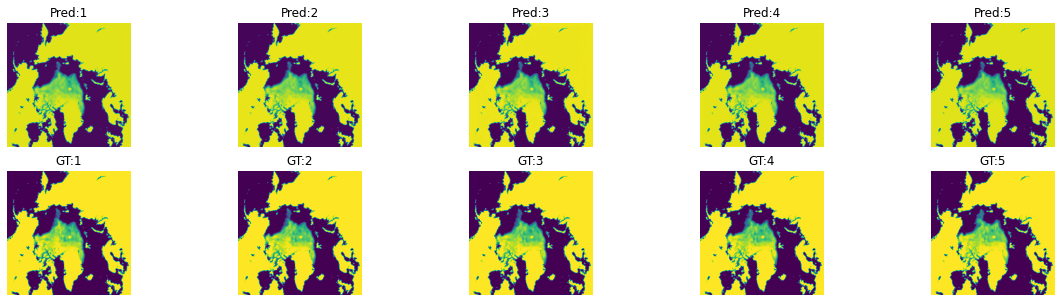

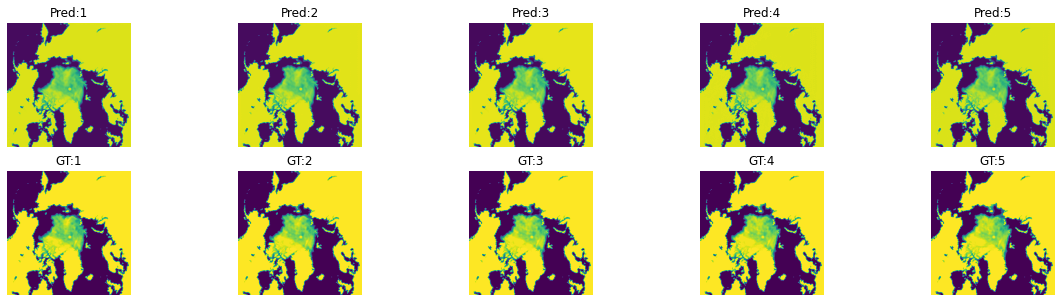

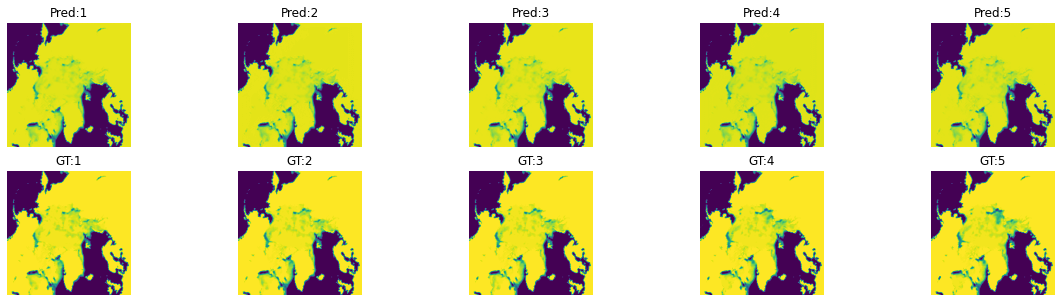

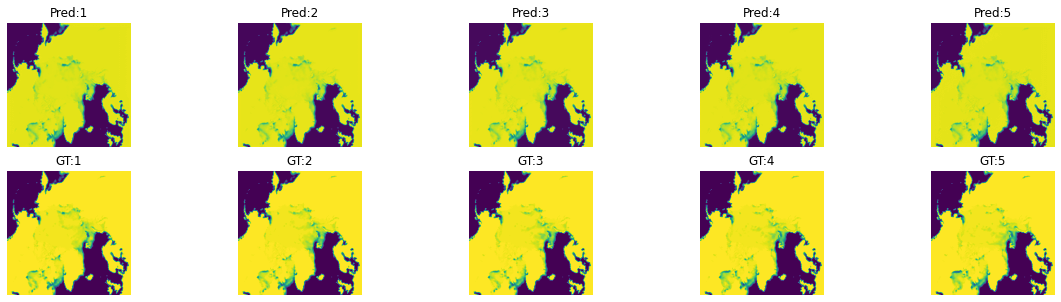

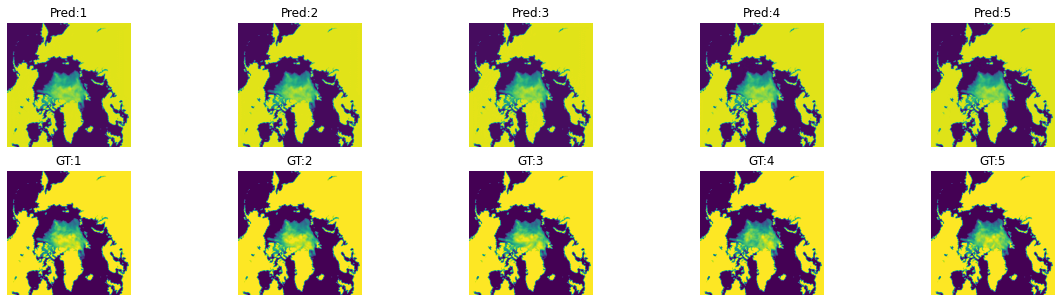

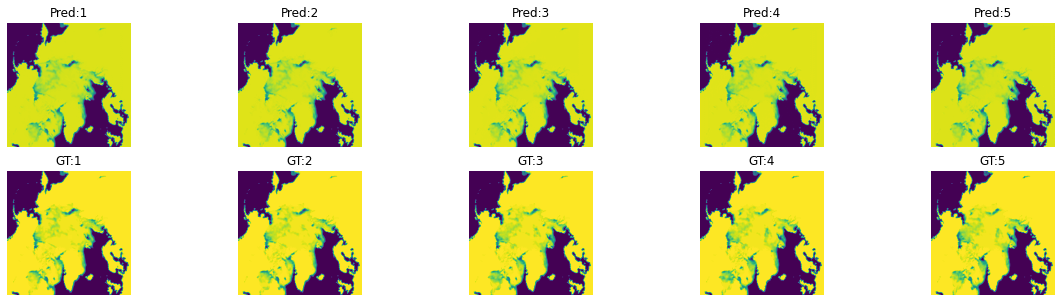

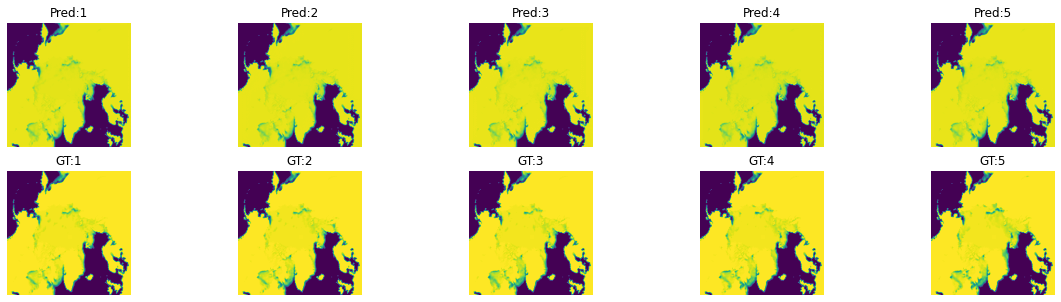

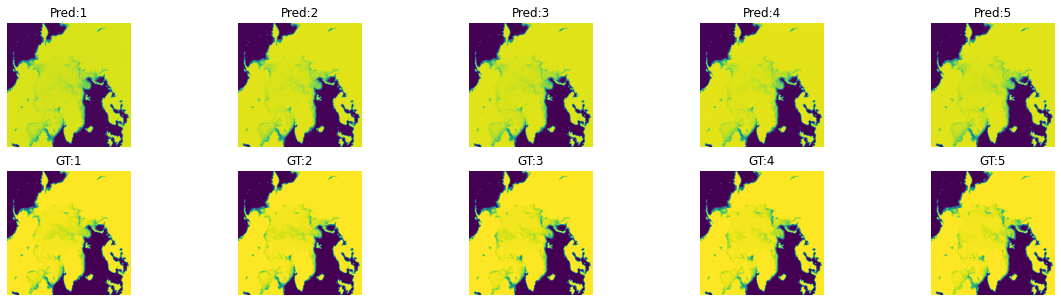

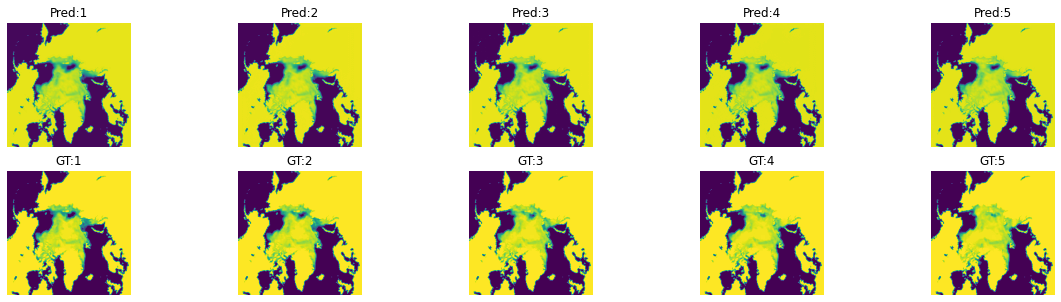

In [ ]:
# Visual pred image
pred_samples = preds[:10]
gt_samples = y_test[:10]
for pred, gt in zip(pred_samples, gt_samples):
    fig = plt.figure(figsize=(20,5))
    for i in range(5):
        ax = fig.add_subplot(2,5,i+1)
        ax.imshow(pred[:, :, i])
        ax.set_title(f'Pred:{i+1}')
        ax.set_axis_off()
    for i in range(5):
        ax = fig.add_subplot(2,5,i+1+5)
        ax.imshow(gt[:, :, i])
        ax.set_title(f'GT:{i+1}')
        ax.set_axis_off()

    plt.show()
    plt.close('all')